# Module

In [1]:
import optuna
import janestreet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Dataset

In [2]:
%%time

train  = pd.read_csv('/kaggle/input/jane-street-market-prediction/train.csv')

print(train.shape)
train.head()

# all train shape (2390491, 138)

(2390491, 138)
CPU times: user 1min 29s, sys: 7.2 s, total: 1min 36s
Wall time: 2min 45s


,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,...,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id
0,0,0.000000,0.009916,0.014079,0.008773,0.001390,0.006270,1,-1.872746,-2.191242,...,NaN,1.168391,8.313583,1.782433,14.018213,2.653056,12.600292,2.301488,11.445807,0
1,0,16.673515,-0.002828,-0.003226,-0.007319,-0.011114,-0.009792,-1,-1.349537,-1.704709,...,NaN,-1.178850,1.777472,-0.915458,2.831612,-1.417010,2.297459,-1.304614,1.898684,1
2,0,0.000000,0.025134,0.027607,0.033406,0.034380,0.023970,-1,0.812780,-0.256156,...,NaN,6.115747,9.667908,5.542871,11.671595,7.281757,10.060014,6.638248,9.427299,2
3,0,0.000000,-0.004730,-0.003273,-0.000461,-0.000476,-0.003200,-1,1.174378,0.344640,...,NaN,2.838853,0.499251,3.033732,1.513488,4.397532,1.266037,3.856384,1.013469,3
4,0,0.138531,0.001252,0.002165,-0.001215,-0.006219,-0.002604,1,-3.172026,-3.093182,...,NaN,0.344850,4.101145,0.614252,6.623456,0.800129,5.233243,0.362636,3.926633,4


In [3]:
example_test = pd.read_csv('../input/jane-street-market-prediction/example_test.csv')

print(example_test.shape)
example_test.head()

(15219, 133)


,weight,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,date,ts_id
0,0.000000,1,-1.872746,-2.191242,-0.474163,-0.323046,0.014688,-0.002484,NaN,NaN,...,1.168391,8.313583,1.782433,14.018213,2.653056,12.600292,2.301488,11.445807,0,0
1,16.673515,-1,-1.349537,-1.704709,0.068058,0.028432,0.193794,0.138212,NaN,NaN,...,-1.178850,1.777472,-0.915458,2.831612,-1.417010,2.297459,-1.304614,1.898684,0,1
2,0.000000,-1,0.812780,-0.256156,0.806463,0.400221,-0.614188,-0.354800,NaN,NaN,...,6.115747,9.667908,5.542871,11.671595,7.281757,10.060014,6.638248,9.427299,0,2
3,0.000000,-1,1.174378,0.344640,0.066872,0.009357,-1.006373,-0.676458,NaN,NaN,...,2.838853,0.499251,3.033732,1.513488,4.397532,1.266037,3.856384,1.013469,0,3
4,0.138531,1,-3.172026,-3.093182,-0.161518,-0.128149,-0.195006,-0.143780,NaN,NaN,...,0.344850,4.101145,0.614252,6.623456,0.800129,5.233243,0.362636,3.926633,0,4


In [4]:
sample_prediction_df = pd.read_csv('../input/jane-street-market-prediction/example_sample_submission.csv')

print(sample_prediction_df.shape)
sample_prediction_df.head()

(15219, 2)


,ts_id,action
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


# Preprocess

In [5]:
train = train[train['weight'] != 0]

print(train.isnull().sum()[1:7])
print('Total Null: ', train.isnull().sum().sum())

weight    0
resp_1    0
resp_2    0
resp_3    0
resp_4    0
resp      0
dtype: int64
Total Null:  5339765


In [6]:
features = train.columns[train.columns.str.contains('feature')]
target = 'action'

print(len(features))
print(features[:2], '...', features[128:])

130
Index(['feature_0', 'feature_1'], dtype='object') ... Index(['feature_128', 'feature_129'], dtype='object')


In [7]:
train = train.fillna(-999)

# train['action'] = ((train['weight'].values * train['resp'].values) > 0).astype('int')
# train['action'] = (train['resp'] > 0) * 1

train['action'] = 0
train.loc[train['resp']>0.0, 'action'] = 1

print(train.isnull().sum().sum())

0


# Modeling

In [8]:
X_train, X_test, y_train, y_test = train_test_split(train[features], train[target], random_state=666, test_size=0.2)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1585029, 130)
(1585029,)
(396258, 130)
(396258,)


In [9]:
'''
def create_model(trial):
    num_leaves = trial.suggest_int("num_leaves", 2, 31)
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 8)
    min_child_samples = trial.suggest_int('min_child_samples', 100, 1200)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 0.99)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 5, 90)
    bagging_fraction = trial.suggest_uniform('bagging_fraction', 0.0001, 1.0)
    feature_fraction = trial.suggest_uniform('feature_fraction', 0.0001, 1.0)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
    tree_method = 'gpu_hist'
    random_state = 666
    
    model = lgb.LGBMClassifier(
        num_leaves=num_leaves,
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        min_child_samples=min_child_samples, 
        min_data_in_leaf=min_data_in_leaf,
        learning_rate=learning_rate,
        feature_fraction=feature_fraction,
        subsample = subsample,
        colsample_bytree = colsample_bytree,
        tree_method = 'gpu_hist',
        random_state = 666)
        
    return model

def objective(trial):
    model = create_model(trial)
    model.fit(X_train, y_train)
    score = roc_auc_score(y_test.values, model.predict_proba(X_test)[:,1])
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40)
params = study.best_params

print(params)

'''

'\ndef create_model(trial):\n    num_leaves = trial.suggest_int("num_leaves", 2, 31)\n    n_estimators = trial.suggest_int("n_estimators", 50, 300)\n    max_depth = trial.suggest_int(\'max_depth\', 3, 8)\n    min_child_samples = trial.suggest_int(\'min_child_samples\', 100, 1200)\n    learning_rate = trial.suggest_uniform(\'learning_rate\', 0.0001, 0.99)\n    min_data_in_leaf = trial.suggest_int(\'min_data_in_leaf\', 5, 90)\n    bagging_fraction = trial.suggest_uniform(\'bagging_fraction\', 0.0001, 1.0)\n    feature_fraction = trial.suggest_uniform(\'feature_fraction\', 0.0001, 1.0)\n    subsample = trial.suggest_uniform(\'subsample\', 0.1, 1.0)\n    colsample_bytree = trial.suggest_uniform(\'colsample_bytree\', 0.1, 1.0)\n    tree_method = \'gpu_hist\'\n    random_state = 666\n    \n    model = lgb.LGBMClassifier(\n        num_leaves=num_leaves,\n        n_estimators=n_estimators, \n        max_depth=max_depth, \n        min_child_samples=min_child_samples, \n        min_data_in_leaf=

In [10]:
params = {'num_leaves': 23,
          'n_estimators': 286,
          'max_depth': 8,
          'min_child_samples': 957,
          'learning_rate': 0.6313484050137067,
          'min_data_in_leaf': 55,
          'bagging_fraction': 0.5706817129820564,
          'feature_fraction': 0.786837269915177,
          'subsample': 0.14168658023733338,
          'colsample_bytree': 0.3711909380163205,
          'tree_method': 'gpu_hist',
          'random_state': 666}

In [11]:
%%time

cls = lgb.LGBMClassifier(**params)
cls.fit(train[features], train[target])

y_proba = cls.predict_proba(X_test)[:,1]

print('AUC: ', roc_auc_score(y_test, y_proba))

AUC:  0.6505758896478027
CPU times: user 5min 53s, sys: 4.73 s, total: 5min 57s
Wall time: 1min 36s


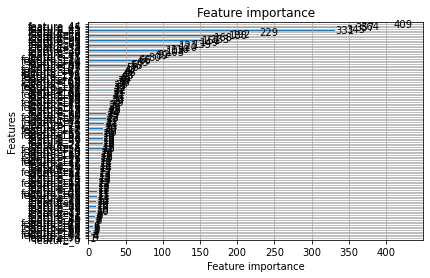

In [12]:
lgb.plot_importance(cls)
plt.show()

# Submit

In [13]:
env = janestreet.make_env()
iter_test = env.iter_test()

In [14]:
'''
%%time

for (test, sample_prediction) in iter_test:
    test = test.fillna(0.5)
    sample_prediction['action'] = cls.predict(test[features])
    env.predict(sample_prediction)
    
'''

"\n%%time\n\nfor (test, sample_prediction) in iter_test:\n    test = test.fillna(0.5)\n    sample_prediction['action'] = cls.predict(test[features])\n    env.predict(sample_prediction)\n    \n"

In [15]:
%%time

for (test, sample_prediction) in iter_test:
    test = test.fillna(-999)
    
    if test['weight'].item() > 0:
        sample_prediction['action'] = cls.predict(test[features])
    else:
        sample_prediction['action'] = 0
    
    env.predict(sample_prediction)

CPU times: user 16min 48s, sys: 29.2 s, total: 17min 17s
Wall time: 4min 26s
